# 高斯过程核与B-spline的对比

In [1]:
import torch
from matplotlib import pyplot as plt
from efficient_kan import KANLinear
layer = KANLinear(72, 1)
# layer = KANLinear(2048, 17) # Pmat
# layer = KANLinear(1728, 28)
# layer = KANLinear(72, 28)

## 参考

https://scikit-learn.org/stable/modules/gaussian_process.html

## Tanh内核

In [2]:
def org_tanh(x, grid, h):
    dist = x[..., None] - grid
    # return torch.tanh(dist / h) 
    return torch.tanh(1 - 0.5 * (dist / h) ** 2)

# def tanh(x, grid, h):
#     dist = x[..., None] - grid
#     return (torch.tanh(dist / h) + 1) / 2  # 将值域从 [-1, 1] 映射到 [0, 1]

# tanh_basis = org_tanh(x, torch.linspace(-2, 2, 8), 0.2)
# tanh_basis.shape

## 径向基函数 (RBF) 内核

In [3]:
def rbf(x, grid, h):
    dist = x[..., None] - grid
    return torch.exp(-0.5 * (dist / h) ** 2)

# rbf_basis = rbf(x, torch.linspace(-2, 2, 8), 0.2)
# rbf_basis.shape

## Matérn 内核

In [4]:
def matern(x, grid, h, nu=1.5):
    dist = torch.abs(x[..., None] - grid)
    if nu == 0.5:
        return torch.exp(-dist / h)
    elif nu == 1.5:
        coeff = (1 + torch.sqrt(torch.tensor(3.0, device=x.device)) * dist / h)
        return coeff * torch.exp(-torch.sqrt(torch.tensor(3.0, device=x.device)) * dist / h)
    elif nu == 2.5:
        coeff = (1 + torch.sqrt(torch.tensor(5.0, device=x.device)) * dist / h + (5 * dist**2) / (3 * h**2))
        return coeff * torch.exp(-torch.sqrt(torch.tensor(5.0, device=x.device)) * dist / h)
    else:
        # 通用 Matern 核函数
        from scipy.special import kv, gamma
        import numpy as np
        coeff = (2 ** (1 - nu)) / gamma(nu)
        bessel_arg = (torch.sqrt(torch.tensor(2 * nu, device=x.device)) * dist) / h
        bessel_term = torch.tensor(kv(nu, bessel_arg.cpu().numpy()), device=x.device)
        return coeff * (bessel_arg ** nu) * bessel_term

# matern_basis = matern(x, torch.linspace(-2, 2, 8), 0.2, nu=1.5)
# matern_basis.shape

## 有理二次核 (Rational Quadratic Kernel)

In [5]:
def rational_quadratic(x, grid, h, alpha=1.0):
    dist = x[..., None] - grid
    return (1 + (dist ** 2) / (2 * alpha * h ** 2)) ** (-alpha)

# rational_quadratic_basis = rational_quadratic(x, torch.linspace(-2, 2, 8), 0.2, alpha=1.0)
# rational_quadratic_basis.shape

## 有理基函数(Rational Base Kernel)

In [6]:
def rational_base_kernel(x, grid, h, m=1, n=1):
    """
    有理基函数核

    参数:
    - x: 输入数据，形状为 [..., D]
    - grid: 网格点，形状为 [N, D]
    - h: 长度参数
    - m: 分子多项式的次数
    - n: 分母多项式的次数

    返回:
    - 核函数值，形状为 [..., N]
    """
    dist = x[..., None] - grid  # 计算x和grid之间的距离
    squared_dist = dist ** 2  # 平方距离

    numerator = 1 + (squared_dist / (2 * h ** 2)) ** m  # 分子部分
    denominator = 1 + (squared_dist / (2 * h ** 2)) ** n  # 分母部分

    return numerator / denominator

## Exp-Sine-Squared 核

In [7]:
def exp_sine_squared(x, grid, h, periodicity=1.0):
    dist = torch.abs(x[..., None] - grid)
    return torch.exp(-2 * (torch.sin(torch.pi * dist / periodicity) ** 2) / h ** 2)

# exp_sine_squared_basis = exp_sine_squared(x, torch.linspace(-2, 2, 8), 0.2, periodicity=1.0)
# exp_sine_squared_basis.shape

## 点积核 (Dot-Product Kernel)

In [8]:
def dot_product(x, grid):
    # 确保 x 和 grid 都是二维的，适合进行矩阵乘法
    x_flat = x.view(-1, 1)  # 将 x 展平为 (n, 1) 形状
    grid_flat = grid.view(-1, 1)  # 将 grid 展平为 (m, 1) 形状
    return torch.matmul(x_flat, grid_flat.T)

# dot_product_basis = dot_product(x, torch.linspace(-2, 2, 8))
# dot_product_basis.shape

## Tanh + Matern

In [9]:
def tanh_matern(x, grid, h):
    dist = x[..., None] - grid
    tanh_output = torch.tanh(1 - 0.5 * (dist / h / 1.1 ) ** 2)
    tanh_output = torch.clamp(tanh_output, min=0)  # 截取负数部分
    return 1.3 * tanh_output * matern(x, grid, h, nu=2.5)

# tanh_matern_basis = tanh(x, torch.linspace(-2, 2, 8), 0.2)
# tanh_matern_basis.shape

## periodic_kernel

In [10]:
import math
def periodic_kernel(x1, x2, h, period = 2):
    """
    Periodic kernel function to model periodic data.
    """
    # 计算 x1 和 x2 之间的距离
    dist = torch.abs(x1[..., None] - x2)
    # 周期性核的公式
    return torch.exp(-2 * (torch.sin(math.pi * dist / period) ** 2) / h**2)

## 可视化 for periodic_basis

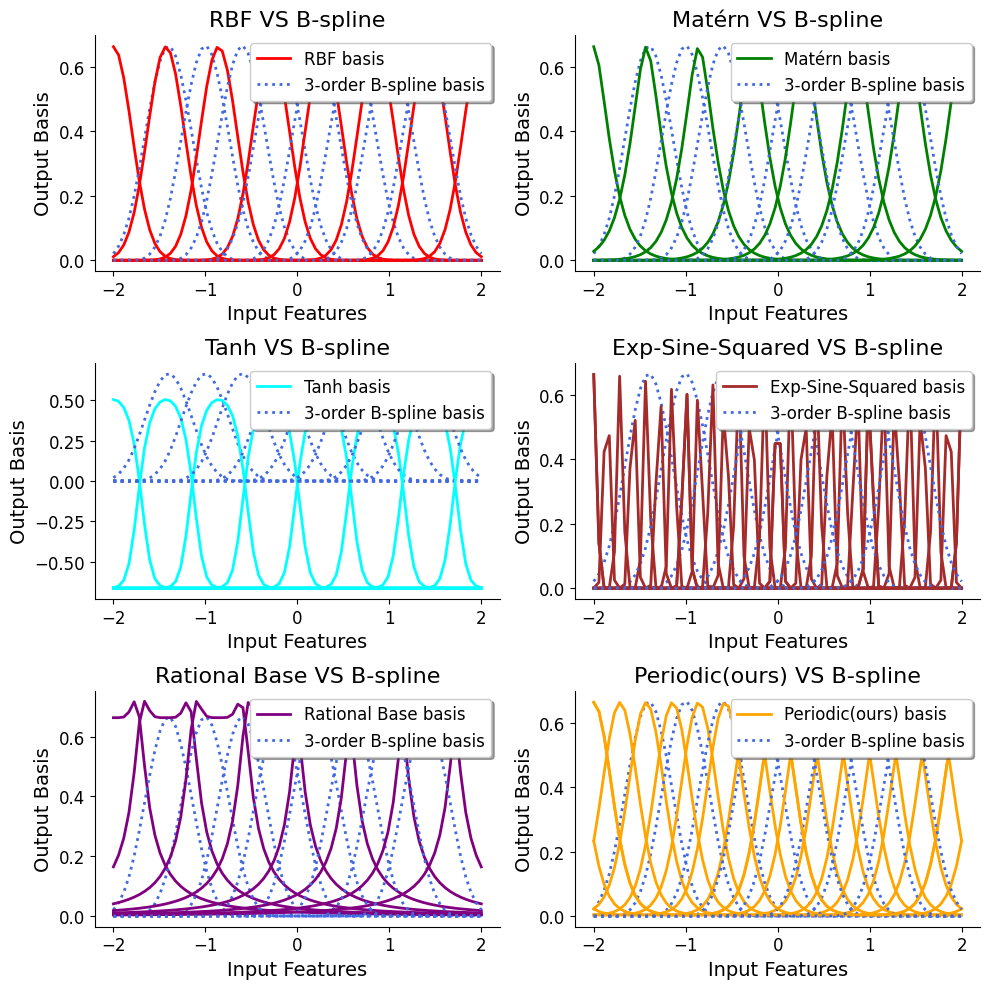

In [11]:
import matplotlib.pyplot as plt
import torch
import os

# 定义一个通用的绘图函数
def plot_basis_comparison(x, bases, kernel_names, kernel_colors, filename):
    # 检查是否存在 figure_result 文件夹，不存在则创建
    if not os.path.exists("figure_result"):
        os.makedirs("figure_result")

    fig, axs = plt.subplots(3, 2, figsize=(10, 10))  # 2行3列的子图
    axs = axs.flatten()  # 将子图转换为1D数组，便于循环
    linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":"]

    for idx, (basis_1, kernel_name, color, ax) in enumerate(zip(bases, kernel_names, kernel_colors, axs)):
        for i in range(8):
            # 绘制 kernel 的基函数
            ax.plot(x.numpy(), basis_1[:, i].numpy() * 0.6631, 
                    color=color, linestyle=linestyles[0], linewidth=2, 
                    label=f"{kernel_name} basis" if i == 0 else None)

            # 绘制 B-spline 的基函数
            ax.plot(x.numpy(), basis[0, :, i].numpy(), 
                    color="royalblue", linestyle=linestyles[3], linewidth=2, 
                    label="3-order B-spline basis" if i == 0 else None)

        ax.set_xlabel("Input Features", fontsize=14)
        ax.set_ylabel("Output Basis", fontsize=14)
        ax.set_title(f"{kernel_name} VS B-spline", fontsize=16)

        # 在每个子图中都显示图例
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 0:
            ax.legend(loc="upper right", fontsize=12, frameon=True, shadow=True)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()  # 自动调整子图布局
    
    # 保存为 SVG 文件到 figure_result 文件夹
    save_path = os.path.join("figure_result", f"{filename}.svg")
    # fig.savefig(save_path, dpi=1000, format='svg', bbox_inches='tight')
    
    plt.show()

# 示例数据（用你实际的数据代替 basis 和 tanh_basis 等）
x = torch.linspace(-2, 2, 72)
basis = layer.b_splines(x[None])  # 三阶 B 样条基函数

# 生成每个核的基函数（使用你之前定义的内核函数）
org_tanh_basis = org_tanh(x, torch.linspace(-2, 2, 8), 0.2)
rbf_basis = rbf(x, torch.linspace(-2, 2, 8), 0.2)
matern_basis = matern(x, torch.linspace(-2, 2, 8), 0.2, nu=1.5)
# rational_quadratic_basis = rational_quadratic(x, torch.linspace(-2, 2, 8), 0.2)
rational_base_basis = rational_base_kernel(x, torch.linspace(-2, 2, 8), 0.2, 3, 4)
exp_sine_squared_basis = exp_sine_squared(x, torch.linspace(-2, 2, 8), 0.2)
# dot_product_basis = dot_product(x, torch.linspace(-2, 2, 8))
# tanh_plus_basis = tanh_matern(x, torch.linspace(-2, 2, 8), 0.2)
periodic_basis = periodic_kernel(x, torch.linspace(-2, 2, 8), 0.6)

# 定义颜色
org_tanh_color = "cyan"  # tanh 基函数颜色保持橙色
rbf_color = "red"
matern_color = "green"
rational_quadratic_color = "purple"
exp_sine_squared_color = "brown"
tanh_plus_color = "orange"

# 将所有基函数、内核名称和对应的颜色放入列表中
bases = [rbf_basis, matern_basis, org_tanh_basis, exp_sine_squared_basis, rational_base_basis, periodic_basis]
kernel_names = ["RBF", "Matérn", "Tanh", "Exp-Sine-Squared", "Rational Base", "Periodic(ours)"]
kernel_colors = [rbf_color, matern_color, org_tanh_color, exp_sine_squared_color, rational_quadratic_color, tanh_plus_color]

# 生成图表并保存到 figure_result 文件夹
plot_basis_comparison(x, bases, kernel_names, kernel_colors, "compare_all_basis")


## 可视化 for mixed tan-matern kernel

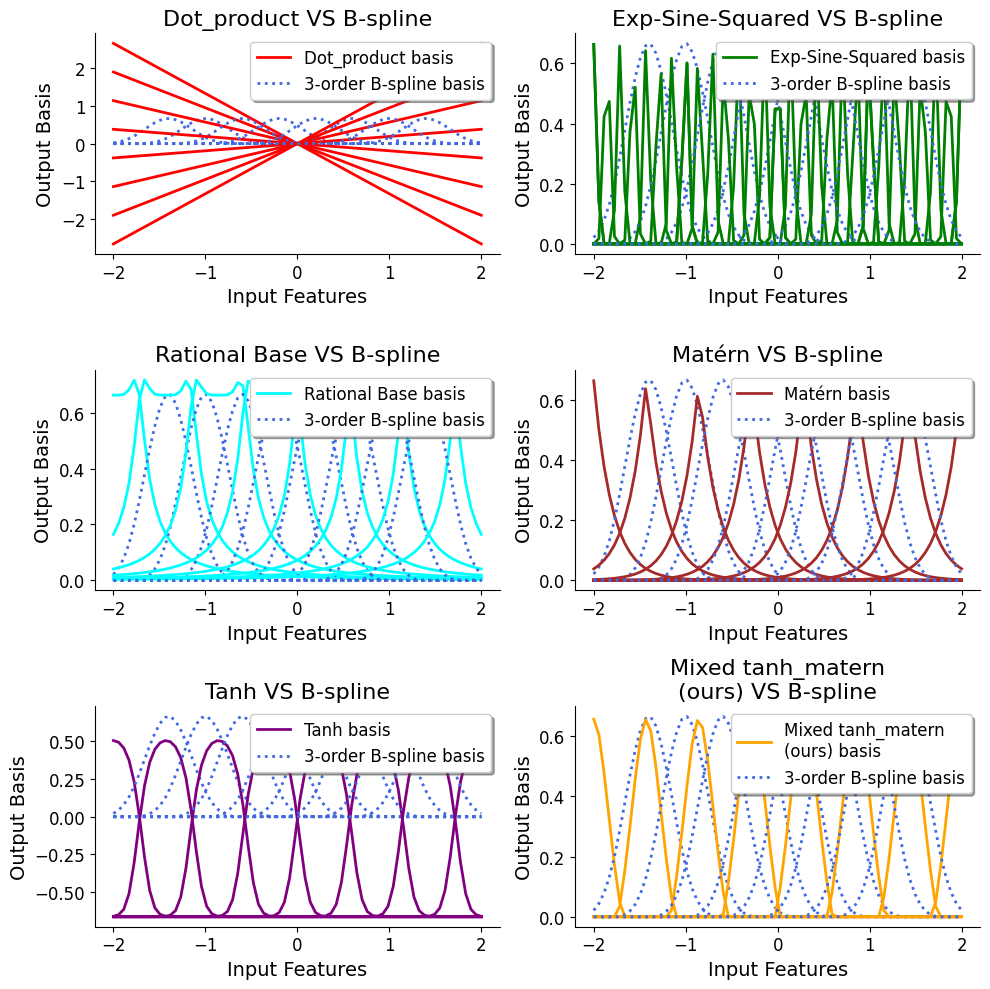

In [12]:
import matplotlib.pyplot as plt
import torch
import os

# 定义一个通用的绘图函数
def plot_basis_comparison(x, bases, kernel_names, kernel_colors, filename):
    # 检查是否存在 figure_result 文件夹，不存在则创建
    if not os.path.exists("figure_result"):
        os.makedirs("figure_result")

    fig, axs = plt.subplots(3, 2, figsize=(10, 10))  # 2行3列的子图
    axs = axs.flatten()  # 将子图转换为1D数组，便于循环
    linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":"]

    for idx, (basis_1, kernel_name, color, ax) in enumerate(zip(bases, kernel_names, kernel_colors, axs)):
        for i in range(8):
            # 绘制 kernel 的基函数
            ax.plot(x.numpy(), basis_1[:, i].numpy() * 0.6631, 
                    color=color, linestyle=linestyles[0], linewidth=2, 
                    label=f"{kernel_name} basis" if i == 0 else None)

            # 绘制 B-spline 的基函数
            ax.plot(x.numpy(), basis[0, :, i].numpy(), 
                    color="royalblue", linestyle=linestyles[3], linewidth=2, 
                    label="3-order B-spline basis" if i == 0 else None)

        ax.set_xlabel("Input Features", fontsize=14)
        ax.set_ylabel("Output Basis", fontsize=14)
        ax.set_title(f"{kernel_name} VS B-spline", fontsize=16)

        # 在每个子图中都显示图例
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 0:
            ax.legend(loc="upper right", fontsize=12, frameon=True, shadow=True)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()  # 自动调整子图布局
    
    # 保存为 SVG 文件到 figure_result 文件夹
    save_path = os.path.join("figure_result", f"{filename}.svg")
    # fig.savefig(save_path, dpi=1000, format='svg', bbox_inches='tight')
    
    plt.show()

# 示例数据（用你实际的数据代替 basis 和 tanh_basis 等）
x = torch.linspace(-2, 2, 72)
basis = layer.b_splines(x[None])  # 三阶 B 样条基函数

# 生成每个核的基函数（使用你之前定义的内核函数）
org_tanh_basis = org_tanh(x, torch.linspace(-2, 2, 8), 0.2)
rbf_basis = rbf(x, torch.linspace(-2, 2, 8), 0.2)
matern_basis = matern(x, torch.linspace(-2, 2, 8), 0.2, nu=0.5)
# rational_quadratic_basis = rational_quadratic(x, torch.linspace(-2, 2, 8), 0.2)
rational_base_basis = rational_base_kernel(x, torch.linspace(-2, 2, 8), 0.2, 3, 4)
exp_sine_squared_basis = exp_sine_squared(x, torch.linspace(-2, 2, 8), 0.2)
dot_product_basis = dot_product(x, torch.linspace(-2, 2, 8))
tanh_matern_basis = tanh_matern(x, torch.linspace(-2, 2, 8), 0.2)
# periodic_basis = periodic_kernel(x, torch.linspace(-2, 2, 8), 0.6)

# 定义颜色
org_tanh_color = "cyan"  # tanh 基函数颜色保持橙色
rbf_color = "red"
matern_color = "green"
rational_quadratic_color = "purple"
exp_sine_squared_color = "brown"
tanh_plus_color = "orange"

# 将所有基函数、内核名称和对应的颜色放入列表中
# bases = [dot_product_basis, matern_basis, org_tanh_basis, exp_sine_squared_basis, rational_base_basis, tanh_matern_basis]
# kernel_names = ["dot_product", "Matérn", "Tanh", "Exp-Sine-Squared", "Rational Base", "Periodic(ours)"]
# kernel_colors = [rbf_color, matern_color, org_tanh_color, exp_sine_squared_color, rational_quadratic_color, tanh_plus_color]

bases = [dot_product_basis, exp_sine_squared_basis, rational_base_basis, matern_basis, org_tanh_basis, tanh_matern_basis]
kernel_names = ["Dot_product", "Exp-Sine-Squared", "Rational Base", "Matérn", "Tanh", "Mixed tanh_matern\n(ours)"]
kernel_colors = [rbf_color, matern_color, org_tanh_color, exp_sine_squared_color, rational_quadratic_color, tanh_plus_color]

# 生成图表并保存到 figure_result 文件夹
plot_basis_comparison(x, bases, kernel_names, kernel_colors, "compare_all_basis_with_tan-matern")


## 可视化matern kernel与b-spline

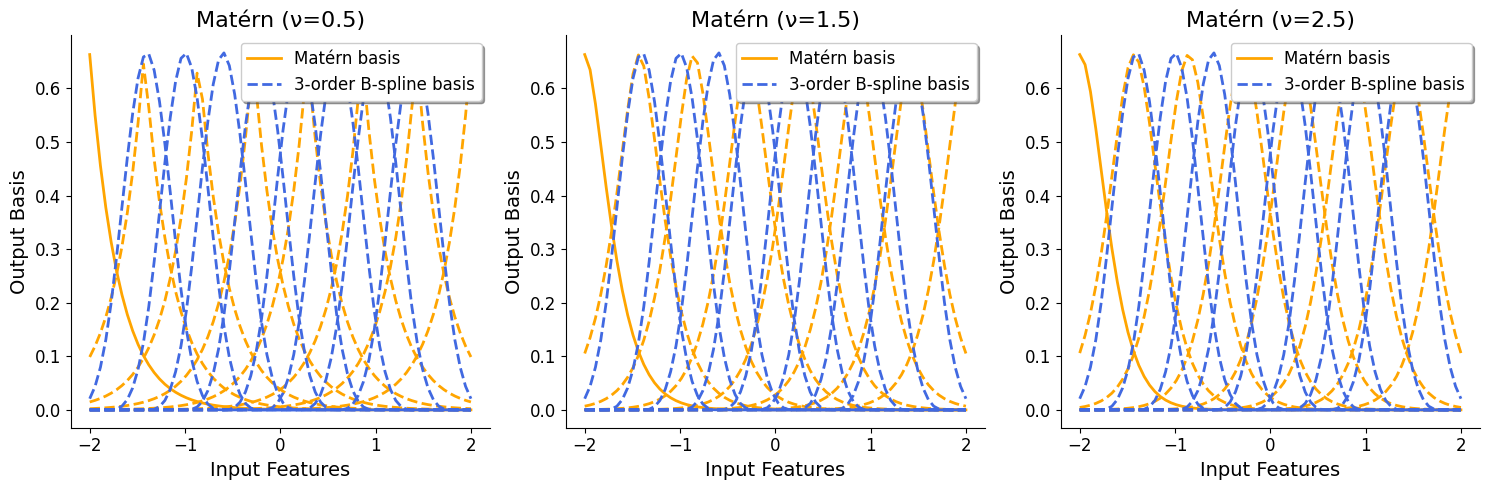

In [13]:
import matplotlib.pyplot as plt
import torch
import os
from scipy.special import kv, gamma

def matern(x, grid, h, nu=1.5):
    dist = torch.abs(x[..., None] - grid)
    if nu == 0.5:
        return torch.exp(-dist / h)
    elif nu == 1.5:
        coeff = (1 + torch.sqrt(torch.tensor(3.0, device=x.device)) * dist / h)
        return coeff * torch.exp(-torch.sqrt(torch.tensor(3.0, device=x.device)) * dist / h)
    elif nu == 2.5:
        coeff = (1 + torch.sqrt(torch.tensor(5.0, device=x.device)) * dist / h + (5 * dist**2) / (3 * h**2))
        return coeff * torch.exp(-torch.sqrt(torch.tensor(5.0, device=x.device)) * dist / h)
    else:
        coeff = (2 ** (1 - nu)) / gamma(nu)
        bessel_arg = (torch.sqrt(torch.tensor(2 * nu, device=x.device)) * dist) / h
        bessel_term = torch.tensor(kv(nu, bessel_arg.cpu().numpy()), device=x.device)
        return coeff * (bessel_arg ** nu) * bessel_term

def plot_basis_comparison(x, basis_1, basis_2, kernel_name, filename, num_columns=3):
    if not os.path.exists("figure_result"):
        os.makedirs("figure_result")

    fig, axs = plt.subplots(1, num_columns, figsize=(15, 5))  # 创建一行多列的子图

    nu_values = [0.5, 1.5, 2.5]  # 不同的nu参数值

    for i, nu in enumerate(nu_values):
        basis_1 = matern(x, torch.linspace(-2, 2, 8), 0.3, nu=nu)
        for j in range(8):
            axs[i].plot(x.numpy(), basis_1[:, j].numpy() * 0.6631, 
                        color="orange", linestyle="-" if j == 0 else "--", linewidth=2,  
                        label=f"{kernel_name} basis" if j == 0 else None)
        for j in range(8):
            axs[i].plot(x.numpy(), basis_2[0, :, j].numpy(), 
                        color="royalblue", linestyle="--", linewidth=2,  
                        label="3-order B-spline basis" if j == 0 else None)
        axs[i].set_title(f"{kernel_name} (ν={nu})", fontsize=16)
        axs[i].set_xlabel("Input Features", fontsize=14)
        axs[i].set_ylabel("Output Basis", fontsize=14)
        handles, labels = axs[i].get_legend_handles_labels()
        if len(handles) > 0:
            axs[i].legend(loc="upper right", fontsize=12, frameon=True, shadow=True)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()  # 自动调整子图布局
    
    # 保存为 PNG 文件到 figure_result 文件夹
    save_path = os.path.join("figure_result", f"{filename}.png")
    fig.savefig(save_path, dpi=300, format='png', bbox_inches='tight')
    
    plt.show()

# 示例数据（用你实际的数据代替 basis 和 tanh_basis 等）
x = torch.linspace(-2, 2, 72)
basis = layer.b_splines(x[None])  # 三阶 B 样条基函数

plot_basis_comparison(x, basis, basis, "Matérn", "matern_vs_bspline", num_columns=3)

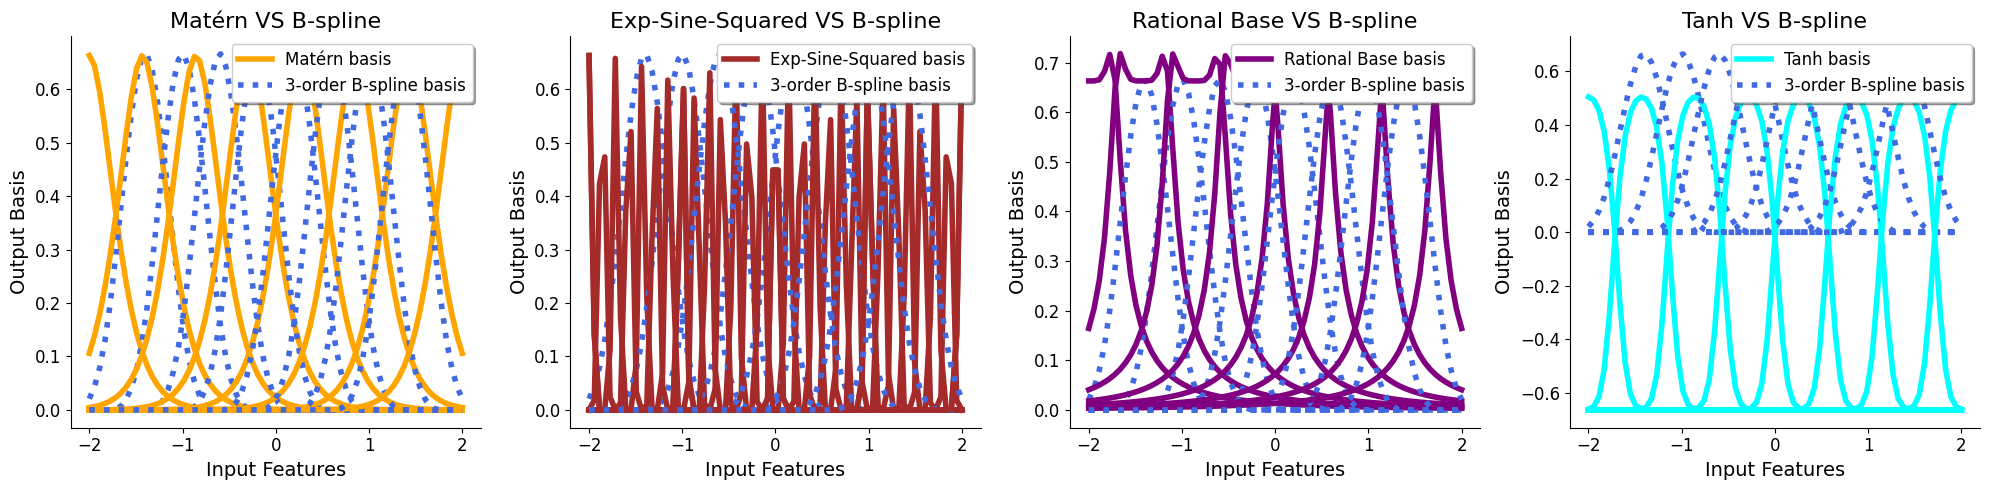

In [15]:
import matplotlib.pyplot as plt
import torch
import os

# 定义一个通用的绘图函数
def plot_basis_comparison(x, bases, kernel_names, kernel_colors, filename):
    # 检查是否存在 figure_result 文件夹，不存在则创建
    if not os.path.exists("figure_result"):
        os.makedirs("figure_result")

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1行4列的子图
    axs = axs.flatten()  # 将子图转换为1D数组，便于循环
    linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":"]

    for idx, (basis_1, kernel_name, color, ax) in enumerate(zip(bases, kernel_names, kernel_colors, axs)):
        for i in range(8):
            # 绘制 kernel 的基函数
            ax.plot(x.numpy(), basis_1[:, i].numpy() * 0.6631, 
                    color=color, linestyle=linestyles[0], linewidth=4,  # 线条加粗
                    label=f"{kernel_name} basis" if i == 0 else None)

            # 绘制 B-spline 的基函数
            ax.plot(x.numpy(), basis[0, :, i].numpy(), 
                    color="royalblue", linestyle=linestyles[3], linewidth=4,  # 线条加粗
                    label="3-order B-spline basis" if i == 0 else None)

        ax.set_xlabel("Input Features", fontsize=14)
        ax.set_ylabel("Output Basis", fontsize=14)
        ax.set_title(f"{kernel_name} VS B-spline", fontsize=16)

        # 在每个子图中都显示图例
        handles, labels = ax.get_legend_handles_labels()
        if len(handles) > 0:
            ax.legend(loc="upper right", fontsize=12, frameon=True, shadow=True)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()  # 自动调整子图布局
    
    # 保存为 SVG 文件到 figure_result 文件夹
    save_path = os.path.join("figure_result", f"{filename}.svg")
    fig.savefig(save_path, dpi=300, format='png', bbox_inches='tight')
    fig.savefig(save_path, dpi=300, format='svg', bbox_inches='tight')
    
    plt.show()

# 示例数据（用你实际的数据代替 basis 和 tanh_basis 等）
x = torch.linspace(-2, 2, 72)
basis = layer.b_splines(x[None])  # 三阶 B 样条基函数

# 生成每个核的基函数（使用你之前定义的内核函数）
matern_basis = matern(x, torch.linspace(-2, 2, 8), 0.3, nu=2.5)
exp_sine_squared_basis = exp_sine_squared(x, torch.linspace(-2, 2, 8), 0.2)
rational_base_basis = rational_base_kernel(x, torch.linspace(-2, 2, 8), 0.2, 3, 4)
org_tanh_basis = org_tanh(x, torch.linspace(-2, 2, 8), 0.2)

# 定义颜色
matern_color = "orange"
exp_sine_squared_color = "brown"
rational_quadratic_color = "purple"
org_tanh_color = "cyan"  # tanh 基函数颜色保持橙色

# 将所有基函数、内核名称和对应的颜色放入列表中
bases = [matern_basis, exp_sine_squared_basis, rational_base_basis, org_tanh_basis]
kernel_names = ["Matérn", "Exp-Sine-Squared", "Rational Base", "Tanh"]
kernel_colors = [matern_color, exp_sine_squared_color, rational_quadratic_color, org_tanh_color]

# 生成图表并保存到 figure_result 文件夹
plot_basis_comparison(x, bases, kernel_names, kernel_colors, "compare_selected_basis_with_b_spline")